In [40]:
import cv2
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import imageio
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [41]:
# Download the ZIP file containing the images
image_path='/content/drive/MyDrive/ACV/Assignment-1/TEST_IMAGES/house.tif'

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


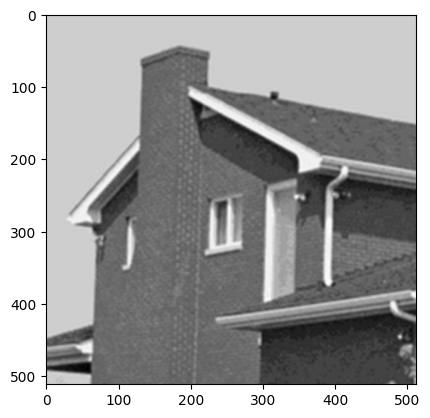

In [43]:
# Reading the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Converting the image to PyTorch tensor
image_tensor = torch.tensor(image)

plt.imshow(image_tensor.numpy(), cmap='gray')
# image_tensor = torch.tensor(image, device=device)
plt.show()

In [44]:
#Creating a 2D Gaussian kernel based on the provided sigma and width parameters.
#Convering it to PyTorch tensor and convolve the input image with LoG filter.

def laplacian_of_gaussian(image, sigma, width):

    x, y = np.meshgrid(np.arange(-width//2+1, width//2+1), np.arange(-width//2+1, width//2+1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    log_filter = torch.from_numpy(kernel / np.sum(np.abs(kernel)))
    # log_filter = torch.from_numpy(kernel / np.sum(np.abs(kernel))).float().to('cuda')

    n_image = F.conv2d(image.unsqueeze(0).unsqueeze(0).float(), log_filter.unsqueeze(0).unsqueeze(0).float())

    # return n_image.squeeze(0).squeeze(0)
    return n_image.squeeze(0).squeeze(0).cpu()  # Move the result back to CPU

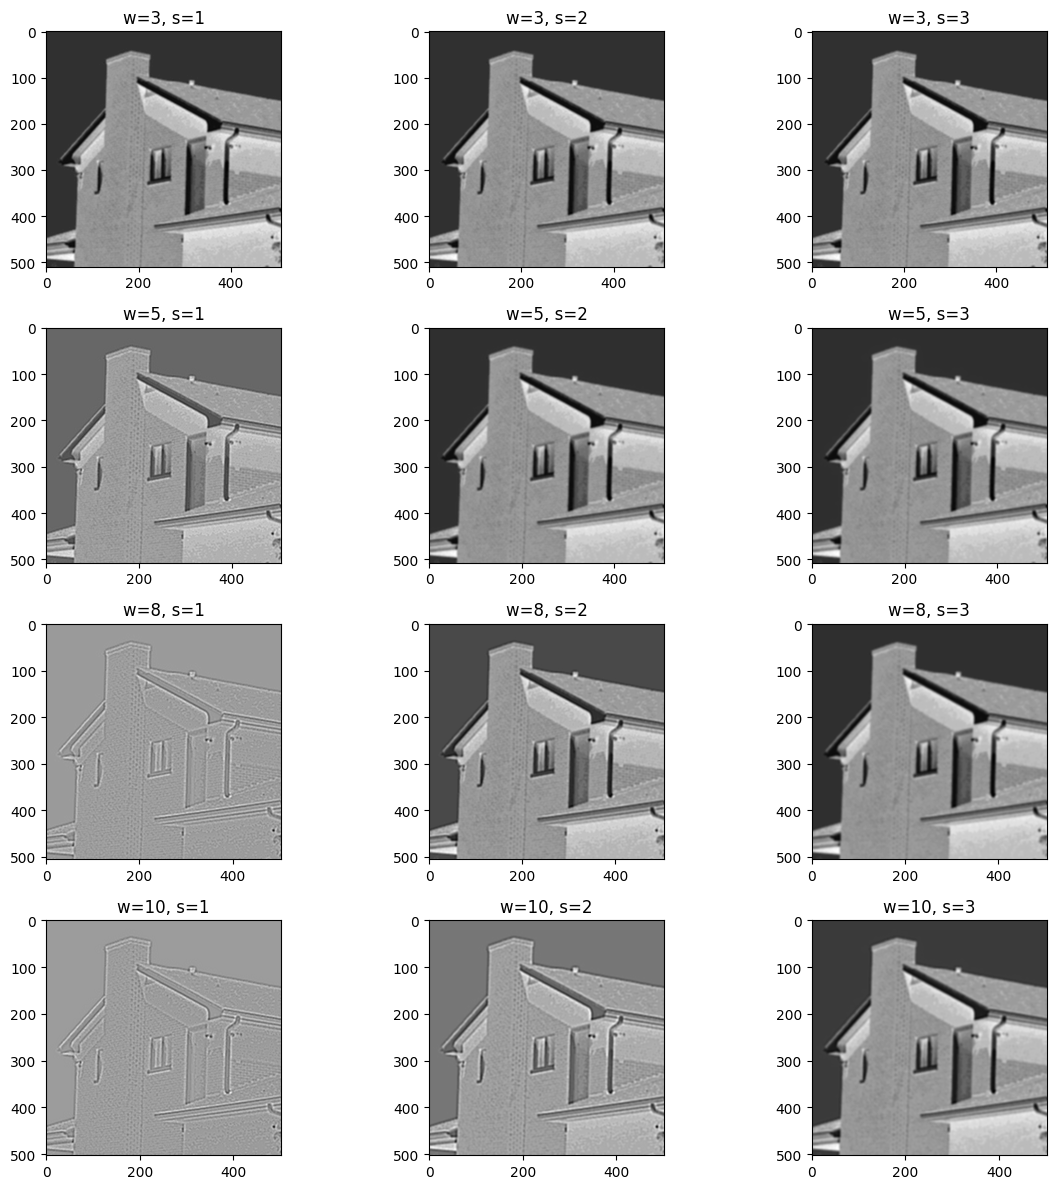

In [45]:
width = [3, 5, 8, 10]
sigma = [1, 2, 3]
edges_ws = []
fig, axs = plt.subplots(len(width), len(sigma), figsize=(12, 12))

for x, w in enumerate(width):
    for y, s in enumerate(sigma):
        edges = laplacian_of_gaussian(image_tensor, sigma=s, width=w)
        edges_ws.append(edges.numpy())
        axs[x, y].imshow(edges.numpy(), cmap='gray')
        axs[x, y].set_title(f'w={w}, s={s}')

plt.tight_layout()
plt.show()

In [46]:
def hough_transform(edge_image, theta_resolution=1, rho_resolution=1):
    # Define the Hough space
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))
    image_height, image_width = edge_image.shape
    diagonal_length = int(np.ceil(np.sqrt(image_width * image_width + image_height * image_height)))
    rhos = np.linspace(-diagonal_length, diagonal_length, diagonal_length * 2)

    # Create the accumulator array and initialize it to zero
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    edge_points_y, edge_points_x = np.nonzero(edge_image)  # Get the indices of edge points

    # Fill the accumulator: for each edge point, increment the cell for each theta
    for point_index in range(len(edge_points_x)):
        x = edge_points_x[point_index]
        y = edge_points_y[point_index]
        for theta_index in range(len(thetas)):
            # Calculate rho. Diagonal_length is added for a positive index
            rho = int((x * np.cos(thetas[theta_index]) + y * np.sin(thetas[theta_index])) + diagonal_length)
            accumulator[rho, theta_index] += 1

    return accumulator, thetas, rhos

In [47]:
#RANSAC line detection

def ransac_line_detection(edge_image, num_lines=10, num_iterations=20, threshold=5):
    edge_points_y, edge_points_x = np.nonzero(edge_image)
    edge_points = list(zip(edge_points_x, edge_points_y))
    detected_lines = []

    for line_idx in range(num_lines):
        best_inliers_count = 0
        best_line = None

        for _ in range(num_iterations):
            # Randomly select 2 points and fit line to these
            random_indices = np.random.choice(len(edge_points), 2, replace=False)
            x1, y1 = edge_points[random_indices[0]]
            x2, y2 = edge_points[random_indices[1]]

            # Line parameters: ax + by + c = 0
            A = y2 - y1
            B = x1 - x2
            C = x2 * y1 - x1 * y2

            # Count inliers, i.e., points close to the line
            inliers_count = sum(1 for x, y in edge_points if np.abs(A * x + B * y + C) / np.sqrt(A ** 2 + B ** 2) < threshold)

            # Check if it's the best line so far
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_line = (A, B, C)

        if best_line:
            detected_lines.append(best_line)
            # Remove inliers from the set to find next line
            edge_points = [(x, y) for x, y in edge_points if np.abs(best_line[0] * x + best_line[1] * y + best_line[2]) / np.sqrt(best_line[0] ** 2 + best_line[1] ** 2) >= threshold]

    return detected_lines


In [48]:
def plot_detected_lines(image, lines):
    if image.ndim == 3 and image.shape[2] == 2:
        image = image[:, :, 0]

    image_height, image_width = image.shape[:2]
    aspect_ratio = image_width / image_height
    figure_size = (10 * aspect_ratio, 10)

    plt.figure(figsize=figure_size)
    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title('Detected Lines')

    for line in lines:
        slope, intercept, residual = line
        if intercept != 0:
            x_coords = np.array([0, image_width])
            y_coords = (-slope / intercept) * x_coords - (residual / intercept)
        else:
            x_coords = np.full(2, -residual / slope)
            y_coords = np.array([0, image_height])

        plt.plot(x_coords, y_coords, 'r')

    plt.xlim([0, image_width])
    plt.ylim([image_height, 0])
    plt.axis('off')
    plt.show()

Lines detected: [(-242, -286, 123794), (74, 120, -56358), (-261, 206, 10492), (128, -108, 3972), (289, 276, -149077), (-51, -43, 26913), (-320, 279, 34796), (403, -361, -22015), (-165, 119, -10291), (411, 395, -198610)]


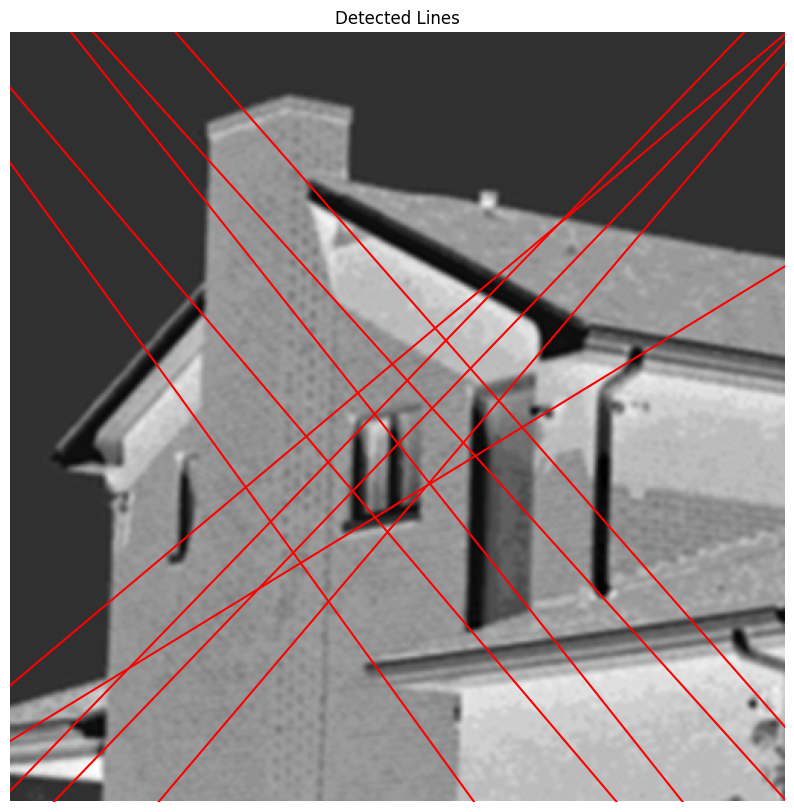

Lines detected: [(215, 265, -103135), (306, -330, -14718), (-40, -47, 26067), (124, 155, -70742), (-408, 453, -17661), (367, 418, -188558), (-107, 175, -35064), (339, -397, 27407), (235, -346, 1469), (-255, 223, 37662)]


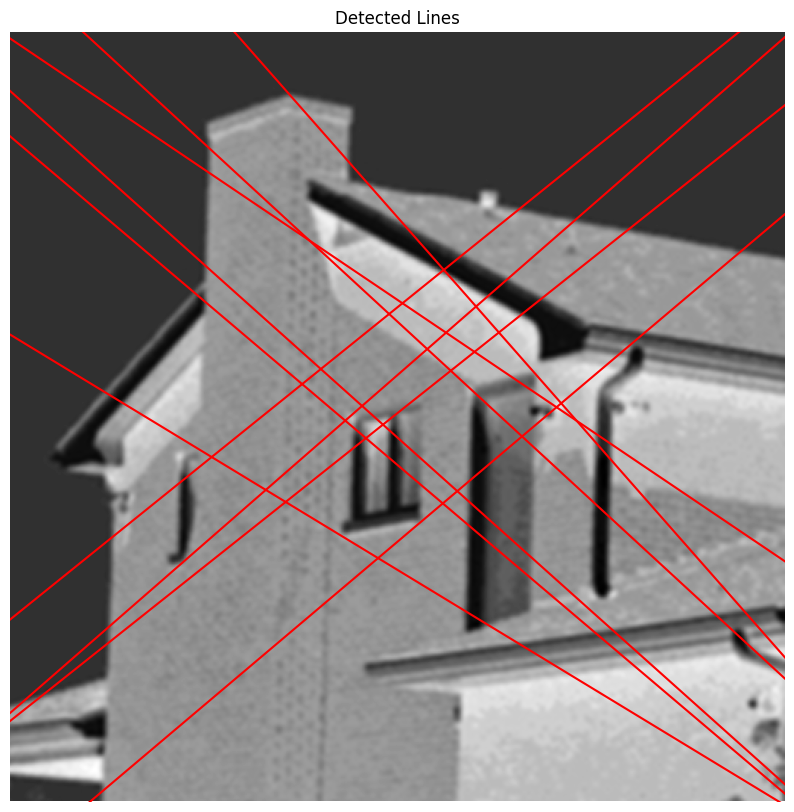

Lines detected: [(142, -123, 5656), (180, 197, -103870), (-417, 338, 31692), (-85, -136, 49453), (-342, 354, 2742), (228, 233, -102930), (131, -131, 3013), (-223, -221, 105209), (-429, 260, 93990), (-13, 21, -3891)]


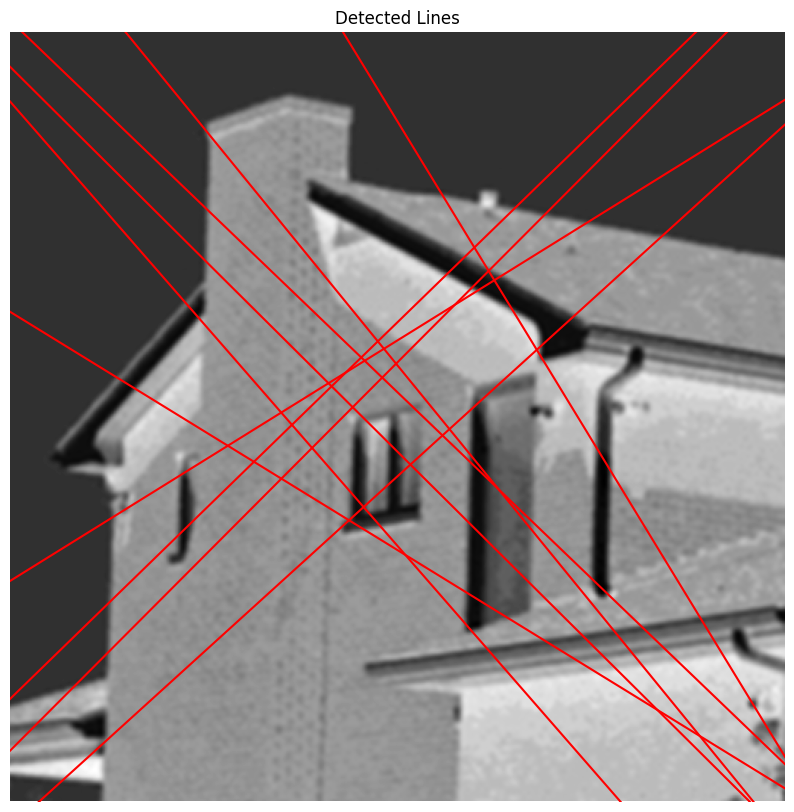

Lines detected: [(350, -220, -60540), (-413, 290, 42441), (-107, 141, -20324), (-89, 56, 18784), (-33, -36, 16455), (226, -262, 2114), (206, 276, -129440), (211, -310, 38186), (-237, -174, 102948), (253, 249, -107875)]


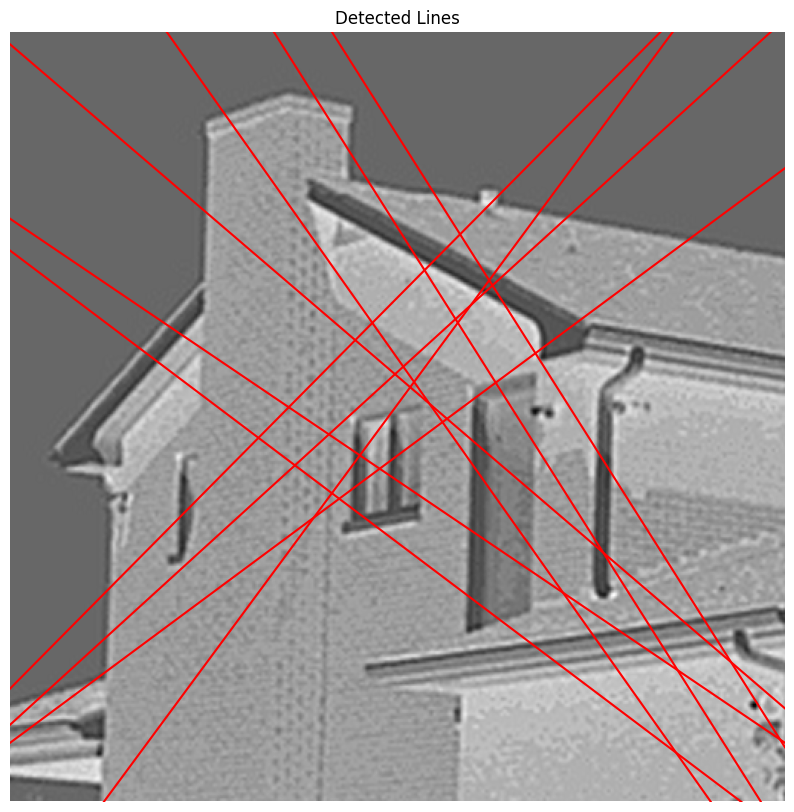

Lines detected: [(-245, 232, 9081), (382, 377, -203016), (-97, -59, 44778), (-113, 102, -66), (472, 369, -193520), (300, -282, 26340), (241, -480, -970), (344, -271, 4200), (-369, -409, 189648), (270, -268, -21616)]


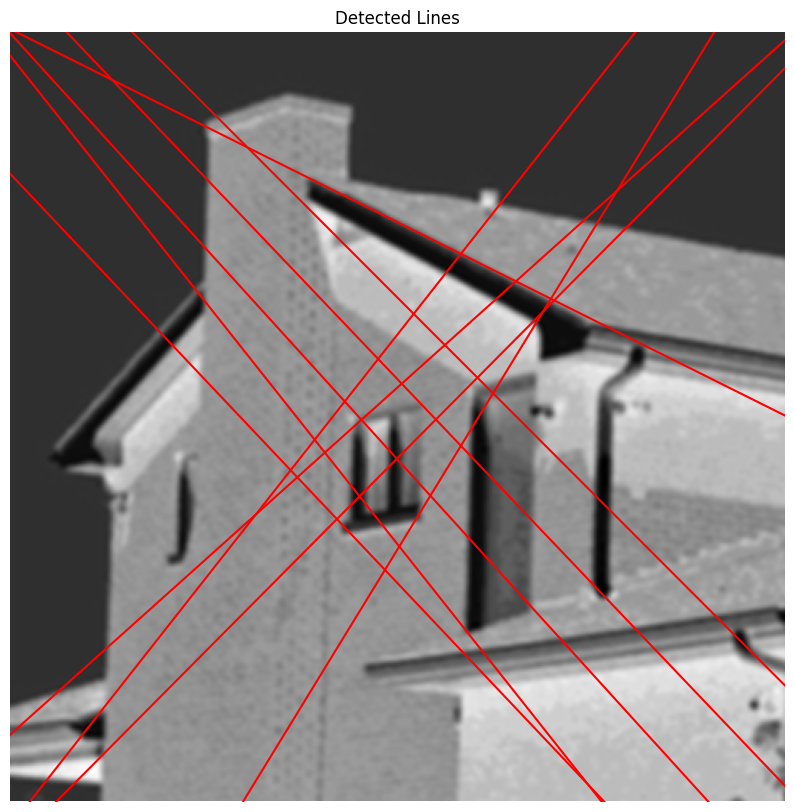

Lines detected: [(228, 219, -124536), (207, -230, 20056), (364, 326, -168938), (341, 243, -119435), (209, -337, 1071), (-286, 353, -5587), (-189, 267, -21864), (317, 195, -155224), (68, -65, 178), (327, 295, -183336)]


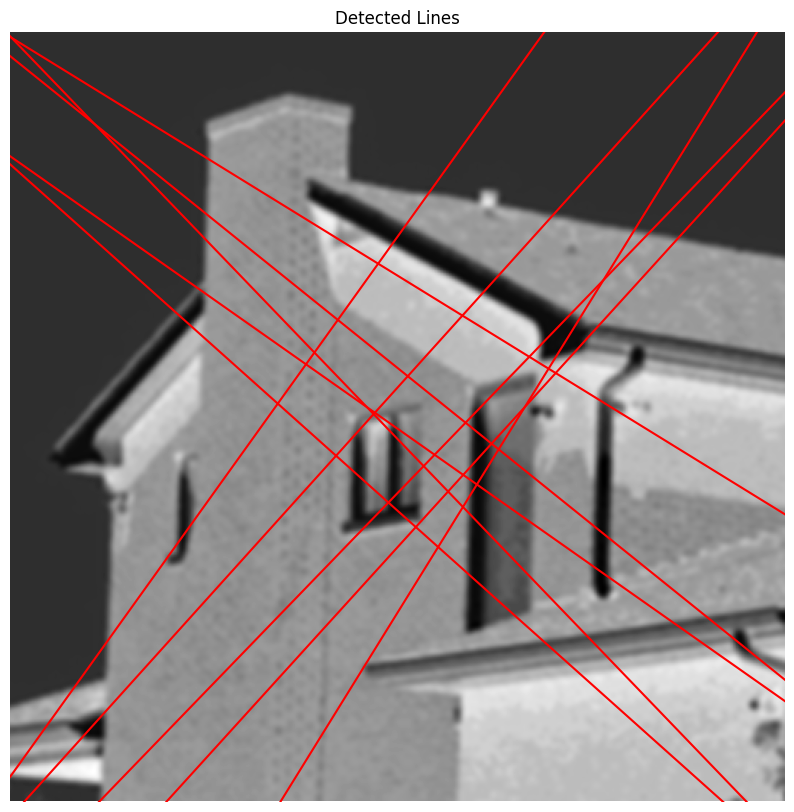

Lines detected: [(-191, 203, -7775), (-303, -240, 156258), (174, -339, 1542), (-208, -238, 115188), (97, -100, 6906), (162, -203, 7000), (-316, -384, 192540), (143, -211, 5665), (-278, -223, 109045), (-37, 25, 4109)]


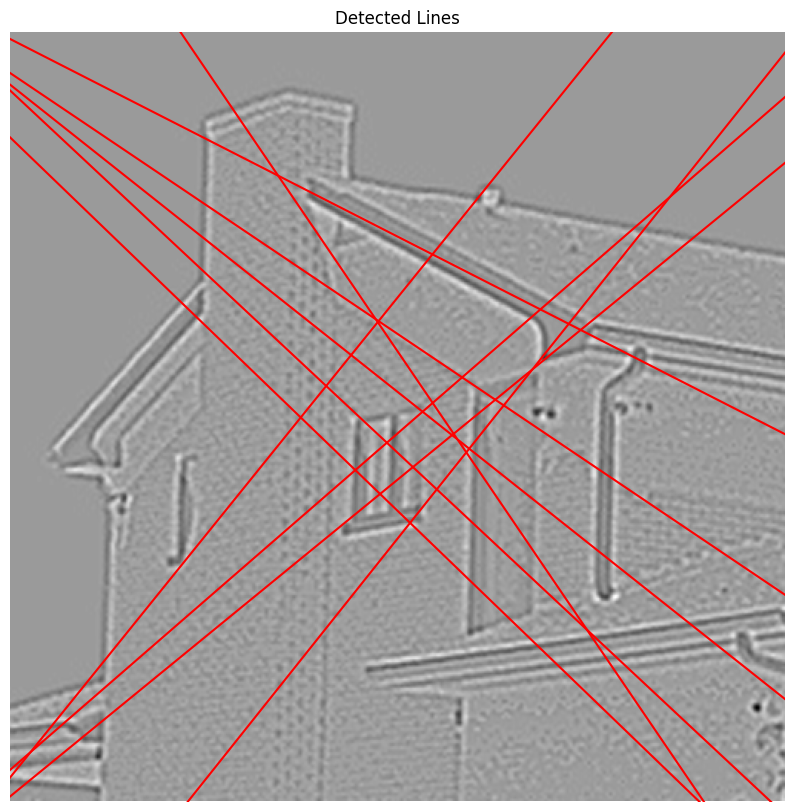

Lines detected: [(290, 249, -142978), (179, -176, 5503), (-116, -129, 56070), (160, -264, -2416), (132, -222, 2010), (473, -461, -12783), (-282, -334, 161764), (122, -120, -5844), (308, -317, 4965), (-117, 172, -32965)]


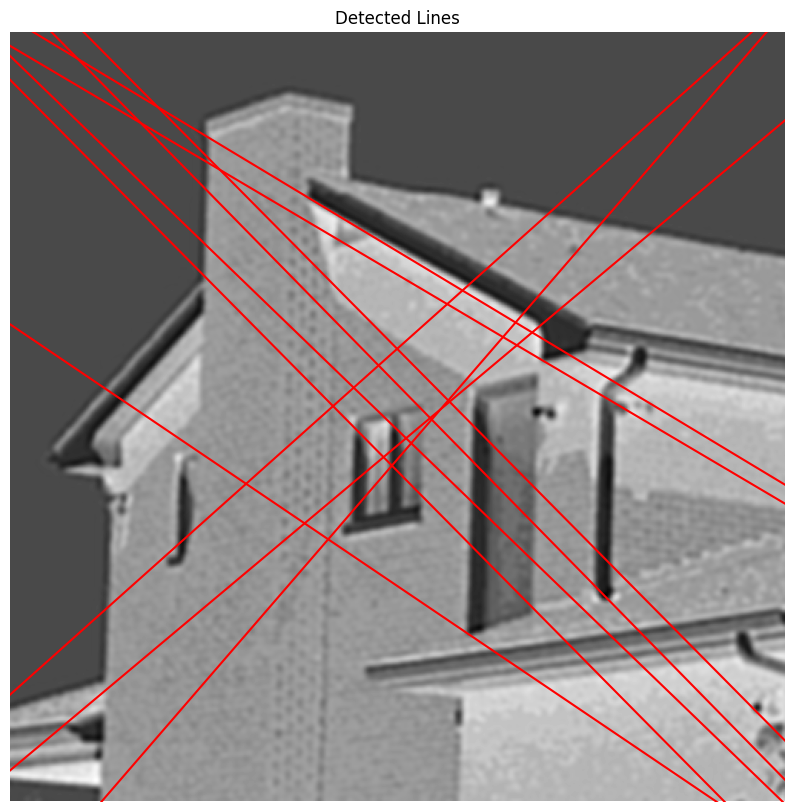

Lines detected: [(-417, -368, 175486), (-272, 298, -782), (295, 320, -166775), (-256, 233, -10583), (152, -157, 4760), (378, 355, -184842), (-333, -222, 165390), (157, -192, -16347), (368, 346, -172202), (350, -317, 26893)]


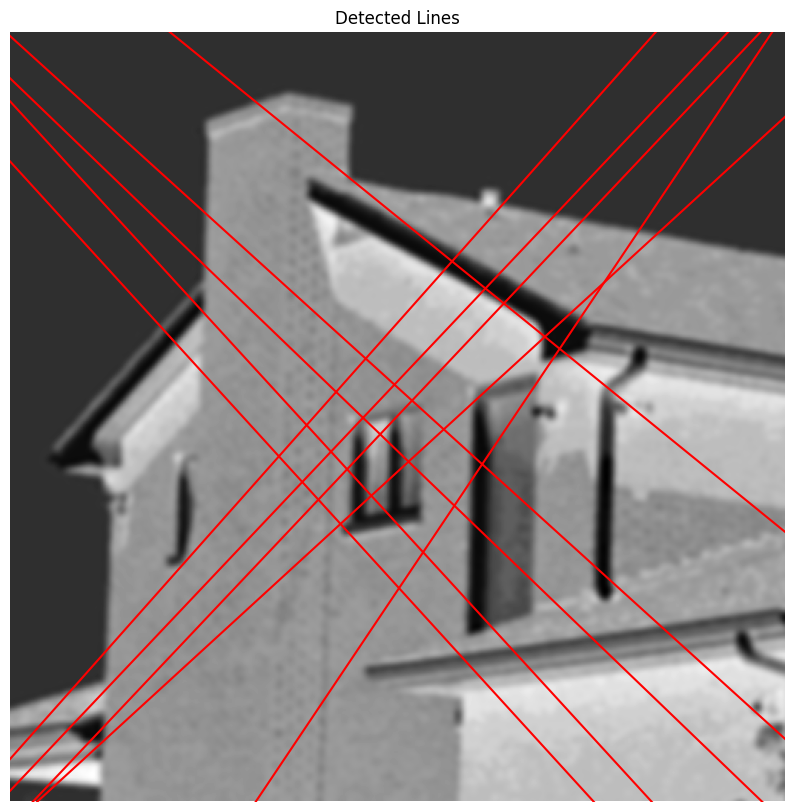

Lines detected: [(-106, 109, 1072), (-337, 236, 23543), (-326, -379, 198204), (312, 312, -127920), (-239, -282, 122332), (-129, -126, 71715), (-263, 260, -5717), (-196, -244, 107620), (-153, 157, -10682), (-240, 122, 62608)]


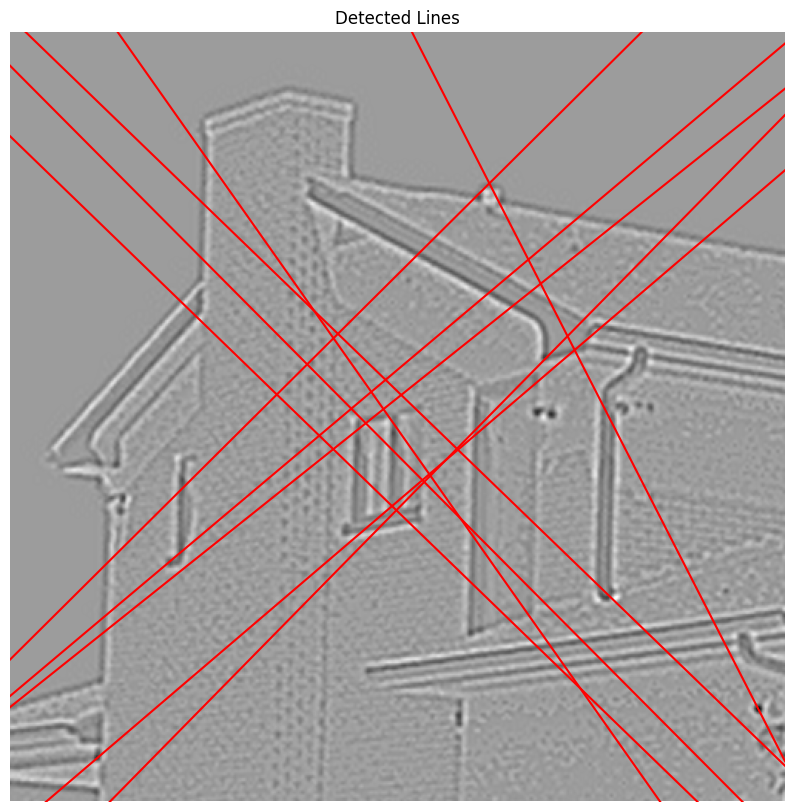

Lines detected: [(-276, 275, 7776), (-225, 239, -14342), (-345, 235, 85), (-331, -396, 168756), (320, 272, -140656), (-282, 277, 926), (277, 155, -77574), (248, -384, -10384), (-192, -183, 113364), (-288, 235, 35582)]


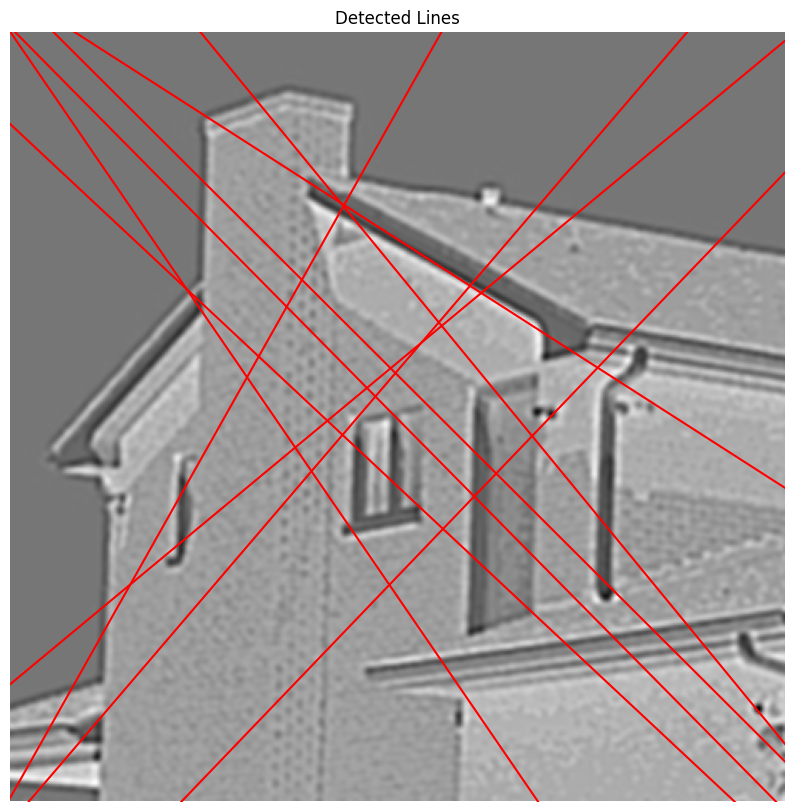

Lines detected: [(333, -299, -21795), (308, 350, -149982), (195, 241, -113999), (129, 159, -70743), (-368, 283, 510), (-373, 367, 155), (90, -95, -2435), (262, 384, -195360), (306, 374, -135626), (-307, 315, -40349)]


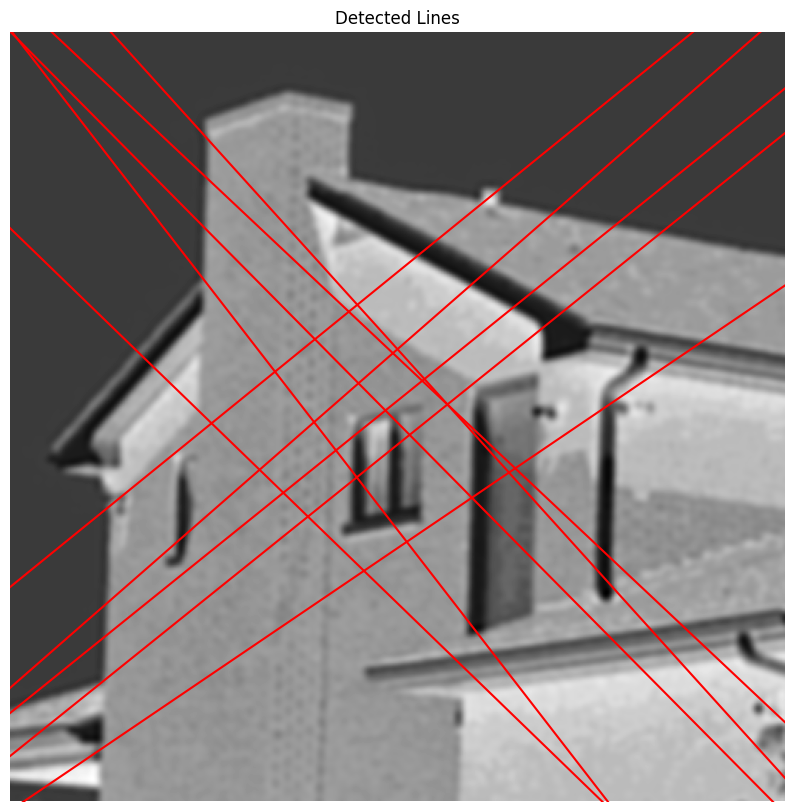

In [49]:

for i in range(len(edges_ws)):
    #Recduced Iteration to 20 as even after using GPU, getting session timeout
    lines = ransac_line_detection(edges_ws[i])
    print("Lines detected:", lines)
    plot_detected_lines(edges_ws[i], lines)

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
